##Importing Libraries and Setup

In [ ]:
!pip install qiskit --quiet

In [ ]:
!pip install cirq --quiet

In [ ]:
import numpy as np
import random
import time
import itertools as itert
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
import numpy as np
import random
import time
import itertools as itert
import cirq
import matplotlib.pyplot as plt
import math
from qiskit import *
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import MCMT
from qiskit.tools.monitor import job_monitor
%matplotlib inline

In [ ]:
from qiskit import QuantumCircuit,execute,Aer
from qiskit.visualization import plot_histogram

##Black Box Function

In [ ]:
#Generates a random 2CNF given m,n
def getFx(m,n,verbose = True):  
  lis = [] 
  coun = 0
  all_tups = []
  while(coun<m):
    s = np.random.choice(n, 2, replace=True)
    s = s + 1
  
    sig = np.random.randint(2, size = 2)*2-1
    s = sorted(s*sig)
    if(tuple(s) not in all_tups):
      all_tups.append(tuple(s))
      lis.append(list(s))
      coun += 1
  return lis

In [ ]:
lis = getFx(10,2)  
print(lis)

[[-2, 1], [-2, -2], [-2, 2], [-1, 2], [1, 2], [-2, -1], [-1, -1], [1, 1], [-1, 1], [2, 2]]


##Classical Solver 
which solves the 2CNF and outputs all possible solution and max count


In [ ]:
#Solver which solves the 2CNF and outputs all possible solution and max count
def solve(lis,n):
  dic = {}
  maxx = -1e10
  max_lis = []
  
  for i in range(2**n):
    val = bin(i)[2:].zfill(n)
    list_val = np.asarray(list(map(int,val)))*2-1
    summ = 0
    for j in range(len(lis)):
      summ += (np.sign(list_val[abs(lis[j][0])-1]) == np.sign(lis[j][0])) or (np.sign(list_val[abs(lis[j][1])-1]) == np.sign(lis[j][1]))
    
    dic[val] = summ
  for i in range(2**n):
    val = bin(i)[2:].zfill(n)
  
    if(dic[val]==max(dic.values())):
      max_lis.append(val)
  return max_lis,max(dic.values())    

In [ ]:
#classical solver which outputs 1 if atleast t clauses satisfied
def classical(lis,n,t):
  outs,outs2 = solve(lis,n)
  if(outs2>=t):
    return 1
  else: 
    return 0  

##QAOA modules start


In [ ]:

# Generate mixer matrix
def createMixer(n,beta):
    R = np.array([[np.cos(beta),-1j*np.sin(beta)],[-1j*np.sin(beta),np.cos(beta)]])

    return Operator(R)

In [ ]:
#Gamma matrix
def gamma_matrix(size, gamma):
  matrix_R = np.identity(size, dtype=complex)
  matrix_R[-1][-1] = np.exp(-1j*gamma)
  return matrix_R

In [ ]:
# creating possible seperator gates used in circuit
def obtain_gamma_gates(gamma):
  gate1_rgamma = Operator(gamma_matrix(2, gamma))
  gate2_crgamma = Operator(gamma_matrix(4, -1*gamma))
  gate3_ccrgamma = Operator(gamma_matrix(8, -1*gamma))
  return gate1_rgamma, gate2_crgamma, gate3_ccrgamma

In [ ]:
# creating one unit of circuit for a particular clause
def utility_helper(circuit, line1, line2, qubits, gate1_rgamma, gate2_crgamma, gate3_ccrgamma):
  if(line1 == line2):
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])
    #circuit.append([gate1_rgamma.on(qubits[-1])])
    circuit.unitary(gate1_rgamma, -1)
    #circuit.append([gate2_crgamma.on(qubits[-1], qubits[line1])])
    circuit.unitary(gate2_crgamma, [line1, -1])
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])
  
  else:
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])
    #circuit.append([cirq.X.on(qubits[line2])])
    circuit.x(qubits[line2])
    #circuit.append([gate1_rgamma.on(qubits[-1])])
    circuit.unitary(gate1_rgamma, -1)
    #circuit.append([gate3_ccrgamma.on(qubits[-1], qubits[line1],qubits[line2])])
    circuit.unitary(gate3_ccrgamma, [line2, line1, -1])
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])
    #circuit.append([cirq.X.on(qubits[line2])])
    circuit.x(qubits[line2])
  return circuit

In [ ]:
# creating the whole seperator circuit
def separator_utility(circuit, first, second, qubits, gamma):
  # parsing
  line1 = np.abs(first) - 1
  line2 = np.abs(second) - 1
  gate1_rgamma, gate2_crgamma, gate3_ccrgamma = obtain_gamma_gates(gamma)
  # Negating the qubits
  if(first < 0):
    #meaning the literal is negated
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])
  if(line2!=line1 and second<0):
    #circuit.append([cirq.X.on(qubits[line2])])
    circuit.x(qubits[line2])
  
  circuit = utility_helper(circuit, line1, line2, qubits, gate1_rgamma, gate2_crgamma, gate3_ccrgamma)
  
  # Undoing negation of qubits
  if(first < 0):
    #meaning the literal is negated
    #circuit.append([cirq.X.on(qubits[line1])])
    circuit.x(qubits[line1])  
  if(line2!=line1 and second<0):
    #circuit.append([cirq.X.on(qubits[line2])])
    circuit.x(qubits[line2])
  return circuit

## Main Circuit Implementation

In [ ]:
def runMainCircuit(n,m,t,lis,beta_divs = 3,gamma_divs = 3,repeats=1, verbose = True):
  if(t>m):
    print("Incorrect input parameters, t should be less than equal to number of clauses")
    return 0,0,0,0,0,0,0
  
  # Defining n+1 qubits 
  qubits = QuantumRegister(n+1)
  registers = ClassicalRegister(n)
  
  rv_qr = list()
  for index in range(n+1):
      rv_qr.append(index)
  rv_qr.reverse()

  # Defining start of Cirq program
  c = QuantumCircuit(qubits, registers)  
  # dividing beta space
  betas = np.arange(beta_divs+1)*np.pi/(beta_divs)
  # dividing gamma space
  gamas = 2*np.arange(gamma_divs+1)*np.pi/(gamma_divs)


  # adding Hadamard gates to all qubits
  for index in range(n):
      c.h(qubits[index])

  # setting last qubit to 1
  c.x(qubits[-1])  

  # add X gate in front of helper qubit 
#  c.append(cirq.X(qubits[-1]))   
 
  
  temp_c = c.copy()    
 
  if(lis==[]):

    lis = getFx(m,n)
  #Solving the given 2CNF classically
  aa,bb = solve(lis,n)

  if(verbose):
      print("#######################")
      print("2-CNF generated:")
      print(lis)
  if(verbose):
    print("Solution:", aa)
    print("Count",bb)
    print("#######################")

    

  flag = 0
  ibm_flag = 0
  max_good = -1e10
  ibm_max_good = -1e10
  curr_max = -1e10
  ibm_curr_max = -1e10
 
  global_sep = 0
  global_rest_c = 0
  global_exec = 0
  ibm_global_exec = 0
  for i in range(len(betas)):
     
    u_beta = createMixer(n,betas[i])
    
    for j in range(len(gamas)):
      start = time.time()  
 
      temp_c = c.copy() 

      # Applying Separator

      for iter in range(m):
        first, second = lis[iter]
        if(first != -1*second):
          temp_c = separator_utility(temp_c, first, second, qubits, gamas[j]) 
      mid1 = time.time()    

      
      # Applying Mixer

      for index in range(n):
        temp_c.unitary(u_beta, index)
    
      # measurements
      temp_c.measure(qubits[0:n], registers)


      
      if(verbose and i==0 and j==0):
        print("Quantum Circuit:")
        print(temp_c)
        print("#######################")

      mid2 = time.time() 

      # Qiskit Simulator Start

      #simulator = cirq.Simulator()
      simulator = Aer.get_backend('aer_simulator')
      circ = transpile(temp_c, simulator)
      
      #result = simulator.run(temp_c, repetitions = repeats)
      result = simulator.run(circ, shots = repeats).result()
      
      dic = result.get_counts()
      good_counts = 0
      dictt = list(result.get_counts(circ).keys())
      bit_strings = []
      output_dictt={}
     
      for indice in range((len(dictt))):
        bit_strings.append(list(result.get_counts(circ).keys())[indice][::-1])
        output_dictt[list(result.get_counts(circ).keys())[indice][::-1]] = list(result.get_counts(circ).values())[indice]
      for key_pair, value_pair in output_dictt.items():
        summ = 0
        for pp in range(len(lis)):
          summ += (np.sign(int(key_pair[abs(lis[pp][0])-1])*2-1) == np.sign(int(lis[pp][0]))*2-1) or (np.sign(int(key_pair[abs(lis[pp][1])-1])*2-1) == np.sign(int(lis[pp][1])*2-1))
        if(summ>=t):
          flag = 1
          good_counts += 1
        if(summ>curr_max):
          sol = key_pair
          curr_max = summ
      
      # getting list of bit strings for the run when highest clauses satisfied count was highest
      if(good_counts>=max_good):
        max_good = good_counts    
        final_bit = bit_strings 

      end = time.time() 
      global_sep += (mid1-start)
      global_rest_c += (mid2-mid1)
      global_exec += (end-mid2)
      if (verbose):
        print("beta_div: i=", i, "gamma_div: j=", j)
        print("Normal simulator finished")
      ########################################################################
      # IBM start
      if(verbose):
        print("IBM starting")
      IBMQ.save_account('b5bbcda1a0eff0449582c42c04c3e1339b7d6af1ab309ffd16a8c573da617096454904a5983830ad7cfe7c2f554214b07ae5b642a9603d66dd91404a6cbb5db2')
      provider = IBMQ.load_account()

      backend = provider.backend.ibmq_quito
      transpiled = transpile(temp_c, backend)
      job = backend.run(transpiled, shots = repeats)
      if(verbose):
        print("IBM results obtaining process starts:")

      retrieval = backend.retrieve_job(job.job_id())
      ibm_start = time.time()
      ibm_result = retrieval.result()

      if(verbose):
        print("IBM results obtaining process ends")
        print("IBM accuracy comparisons with the classical output starts")
    
      ibm_good_counts = 0
      ibm_dictt = list(ibm_result.get_counts(circ).keys())
      ibm_bit_strings = []
      ibm_output_dictt={}
      
      for indice in range((len(ibm_dictt))):      
        ibm_bit_strings.append(list(ibm_result.get_counts(circ).keys())[indice][::-1])
        ibm_output_dictt[list(ibm_result.get_counts(circ).keys())[indice][::-1]] = list(ibm_result.get_counts(circ).values())[indice]

      for key_pair, value_pair in ibm_output_dictt.items():
        ibm_summ = 0
        for pp in range(len(lis)):
          ibm_summ += (np.sign(int(key_pair[abs(lis[pp][0])-1])*2-1) == np.sign(int(lis[pp][0]))*2-1) or (np.sign(int(key_pair[abs(lis[pp][1])-1])*2-1) == np.sign(int(lis[pp][1])*2-1))
        if(ibm_summ>=t):
          ibm_flag = 1
          ibm_good_counts += 1
        if(ibm_summ>ibm_curr_max):
          ibm_sol = key_pair
          ibm_curr_max = ibm_summ

      if(ibm_good_counts>=ibm_max_good):
        ibm_max_good = ibm_good_counts    
        ibm_final_bit = ibm_bit_strings
      if(verbose):
        print("IBM accuracy comparisons with the classical output ends")
      
      ibm_end = time.time()
      ibm_global_exec += (ibm_end - ibm_start)



    
  return flag, final_bit, sol, curr_max, global_sep, global_rest_c, global_exec, ibm_global_exec, output_dictt, \
  ibm_flag, ibm_final_bit, ibm_sol, ibm_curr_max, ibm_output_dictt

In [ ]:
#process string to generate the histogram of values for best beta and gamma
def process_string(dic, is_ibm):

  plt.bar(dic.keys(),dic.values())
  
  plt.xticks(rotation='vertical')
  if(is_ibm == False):
    plt.title('Qiskit simulator: no. of matching cases versus the output state vector')
  else:
    plt.title('IBM simulator: no. of matching cases versus the output state vector')
  return plt

##n=1
m = 1, beta_divs = default = 3, gamma_divs = 3, repeats (or shots) = 1000


configrc.store_credentials:WARNING:2022-03-20 19:19:27,222: Credentials already present. Set overwrite=True to overwrite.


#######################
2-CNF generated:
[[-1, 1]]
Solution: ['0', '1']
Count 1
#######################
Quantum Circuit:
        ┌───┐┌─────────┐┌─┐
q555_0: ┤ H ├┤ Unitary ├┤M├
        ├───┤└─────────┘└╥┘
q555_1: ┤ X ├────────────╫─
        └───┘            ║ 
  c2: 1/═════════════════╩═
                         0 
#######################
beta_div: i= 0 gamma_div: j= 0
Normal simulator finished
IBM starting
IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:19:55,288: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:19:55,488: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:20:25,296: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 19:20:25,387: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 2
Normal simulator finished
IBM starting
IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:21:15,448: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:21:15,896: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:21:45,233: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:21:45,433: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:22:15,140: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 19:22:15,286: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 1
Normal simulator finished
IBM starting
IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:22:55,434: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:22:56,078: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:23:35,352: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:23:35,715: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:24:05,264: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:24:05,460: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:24:35,169: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:24:35,815: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:25:05,562: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:25:05,735: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:25:35,310: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:25:35,667: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:26:14,736: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:26:14,941: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:26:45,292: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:26:45,567: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:27:15,322: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 19:27:15,484: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 2
Normal simulator finished
IBM starting
IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:27:45,548: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:27:46,027: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:
IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
#######################################
Output interpretation and plots
Quantum Circuit Output:
There exists z satisfies 1 clauses
One of the Assignment which maximizes count =  1
Number of clauses satisfied 1
Time taken for circuit creation 0.01786518096923828
Time taken for Qiskit simulator execution 0.3330378532409668
Time taken by IBM: 462.0507369041443
Histogram of assignments for 1000 repetitions
histo ['0', '1']
output_dictt {'0': 473, '1': 527}


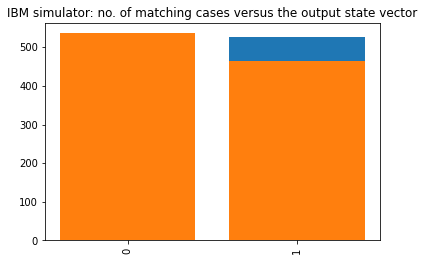

In [ ]:
dic = {0:"does not exist",1: "exists"}
n = 1
m = 1
lis_sam = getFx(m,n,verbose = True)
#[[-3, 1], [-2, 1], [-4, -1], [1, 3], [2, 3], [-1, 2], [-3, -3], [-2, 4], [-3, 4], [-4, 2]]
#getFx(m,n,verbose = True) #[[-2, -1], [1, 2], [2, 2], [-2, 2], [-1, 1], [-1, 2], [-2, 1], [-1, -1], [-2, -2], [1, 1]]

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time, ibm_exec_time, output_dictt,\
ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,m,t,lis_sam,beta_divs = 3, gamma_divs=3, repeats=1000, verbose = True)
#print("histo:", histo)
#print("output_dict:", output_dictt)
print("#######################################")
print("Output interpretation and plots")
if(result>0):
  fin = solution
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for Qiskit simulator execution", exec_time)
  print("Time taken by IBM:", ibm_exec_time)
  print("Histogram of assignments for 1000 repetitions")
  print("histo", histo)
  print("output_dictt", output_dictt)
  pt= process_string(output_dictt, False)
  pt= process_string(ibm_output_dictt, True)



else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")



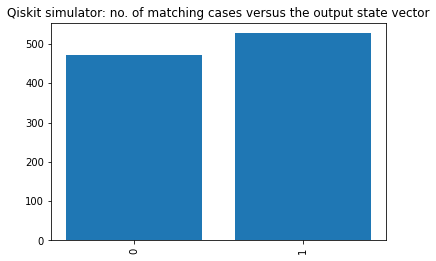

In [ ]:
pt= process_string(output_dictt, False)

##n=2
m = 10, beta_divs = default = 3, gamma_divs = 3, repeats (or shots) = 1000


configrc.store_credentials:WARNING:2022-03-20 19:49:54,069: Credentials already present. Set overwrite=True to overwrite.


#######################
2-CNF generated:
[[1, 1], [-1, 2], [1, 2], [-1, 1], [-2, -1], [-2, 1], [-1, -1], [2, 2], [-2, 2], [-2, -2]]
Solution: ['00', '01', '10', '11']
Count 7
#######################
Quantum Circuit:
         ┌───┐   ┌───┐   ┌──────────┐   ┌───┐   ┌───┐┌───┐┌──────────┐»
q1052_0: ┤ H ├───┤ X ├───┤0         ├───┤ X ├───┤ X ├┤ X ├┤1         ├»
         ├───┤   ├───┤   │          │   └───┘   └───┘└───┘│          │»
q1052_1: ┤ H ├───┤ X ├───┤  Unitary ├─────────────────────┤0 Unitary ├»
         ├───┤┌──┴───┴──┐│          │┌─────────┐          │          │»
q1052_2: ┤ X ├┤ Unitary ├┤1         ├┤ Unitary ├──────────┤2         ├»
         └───┘└─────────┘└──────────┘└─────────┘          └──────────┘»
   c3: 2/═════════════════════════════════════════════════════════════»
                                                                      »
«            ┌───┐   ┌───┐┌───┐┌──────────┐   ┌───┐   ┌───┐┌───┐┌──────────┐»
«q1052_0: ───┤ X ├───┤ X ├┤ X ├┤1         ├───┤ X ├───┤ X 

ibmqfactory.load_account:WARNING:2022-03-20 19:49:54,348: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:50:25,395: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:50:25,566: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:50:55,245: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:50:55,356: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:51:25,481: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:51:25,652: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:51:55,373: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:51:55,729: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:52:25,364: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:52:25,619: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:52:55,535: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:52:56,030: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:53:25,399: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:53:25,784: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:53:55,728: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:53:55,908: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:54:25,796: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:54:25,994: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:54:55,469: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:54:55,697: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:55:25,604: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 2 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:55:25,946: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:55:55,500: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:55:55,855: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:56:25,727: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:56:25,895: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:56:55,502: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 2
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:56:55,684: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 19:57:25,395: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 3 gamma_div: j= 3
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 19:57:25,659: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:
IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
#######################################
Output interpretation and plots
Quantum Circuit Output:
There exists z satisfies 7 clauses
One of the Assignment which maximizes count =  11
Number of clauses satisfied 7
Time taken for circuit creation 0.10803842544555664
Time taken for Qiskit simulator execution 1.5302653312683105
Time taken by IBM: 403.30305767059326
Histogram of assignments for 1000 repetitions
histo ['11', '01', '00', '10']
output_dictt {'11': 245, '01': 268, '00': 228, '10': 259}


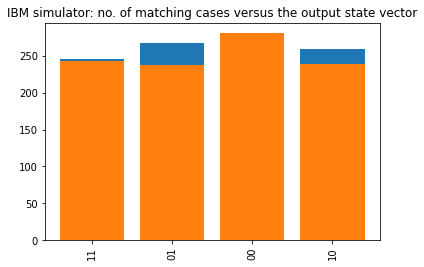

In [ ]:
dic = {0:"does not exist",1: "exists"}
n = 2
m = 10
lis_sam = getFx(m,n,verbose = True)
#[[-3, 1], [-2, 1], [-4, -1], [1, 3], [2, 3], [-1, 2], [-3, -3], [-2, 4], [-3, 4], [-4, 2]]
#getFx(m,n,verbose = True) #[[-2, -1], [1, 2], [2, 2], [-2, 2], [-1, 1], [-1, 2], [-2, 1], [-1, -1], [-2, -2], [1, 1]]

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time, ibm_exec_time, output_dictt,\
ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,m,t,lis_sam,beta_divs = 3, gamma_divs=3, repeats=1000, verbose = True)
#print("histo:", histo)
#print("output_dict:", output_dictt)
print("#######################################")
print("Output interpretation and plots")
if(result>0):
  fin = solution
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for Qiskit simulator execution", exec_time)
  print("Time taken by IBM:", ibm_exec_time)
  print("Histogram of assignments for 1000 repetitions")
  print("histo", histo)
  print("output_dictt", output_dictt)
  pt= process_string(output_dictt, False)
  pt= process_string(ibm_output_dictt, True)



else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")



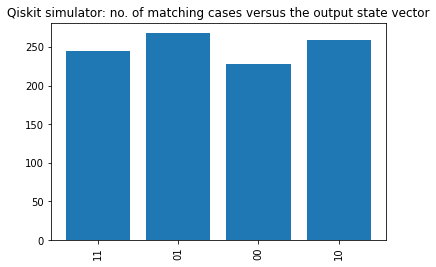

In [ ]:
pt= process_string(output_dictt, False)

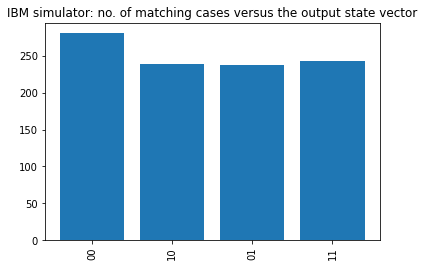

In [ ]:
pt= process_string(ibm_output_dictt, True)

##n = 3
repeats (or shots) = 1000


(Beta and gamma divs were kept to 1, for the sake of avoiding too many calls to the IBM simulator, as now the number of qubits being played with reach 4(including helper qubit). It is further known that beta, gamma when taken substantially varied over their respective ranges, will help in amplifying the good state vectors even more.)

configrc.store_credentials:WARNING:2022-03-20 22:14:59,721: Credentials already present. Set overwrite=True to overwrite.


#######################
2-CNF generated:
[[3, 3], [-2, 3], [-3, 1], [-1, 1], [-3, -1]]
Solution: ['000', '001', '011', '100', '101', '111']
Count 4
#######################
Quantum Circuit:
        ┌───┐   ┌───┐                                                      »
q257_0: ┤ H ├───┤ X ├──────────────────────────────────────────────────────»
        ├───┤   ├───┤      ┌───┐                    ┌──────────┐   ┌───┐   »
q257_1: ┤ H ├───┤ X ├──────┤ X ├────────────────────┤1         ├───┤ X ├───»
        ├───┤   ├───┤   ┌──┴───┴───┐   ┌───┐   ┌───┐│          │   ├───┤   »
q257_2: ┤ H ├───┤ X ├───┤0         ├───┤ X ├───┤ X ├┤0 Unitary ├───┤ X ├───»
        ├───┤┌──┴───┴──┐│  Unitary │┌──┴───┴──┐└───┘│          │┌──┴───┴──┐»
q257_3: ┤ X ├┤ Unitary ├┤1         ├┤ Unitary ├─────┤2         ├┤ Unitary ├»
        └───┘└─────────┘└──────────┘└─────────┘     └──────────┘└─────────┘»
  c1: 3/═══════════════════════════════════════════════════════════════════»
                                         

ibmqfactory.load_account:WARNING:2022-03-20 22:15:00,923: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:15:39,047: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:15:39,775: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:16:08,442: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:16:09,223: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:16:38,765: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:16:39,491: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:
IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
#######################################
Output interpretation and plots
Quantum Circuit Output:
There exists z satisfies 4 clauses
One of the Assignment which maximizes count =  101
Number of clauses satisfied 4
Time taken for circuit creation 0.01877617835998535
Time taken for Qiskit simulator execution 0.17588114738464355
Time taken by IBM: 87.10281729698181
Histogram of assignments for 1000 repetitions
histo ['100', '101', '010', '110', '000', '111', '011', '001']
output_dictt {'100': 141, '101': 130, '010': 124, '110': 116, '000': 135, '111': 119, '011': 109, '001': 126}


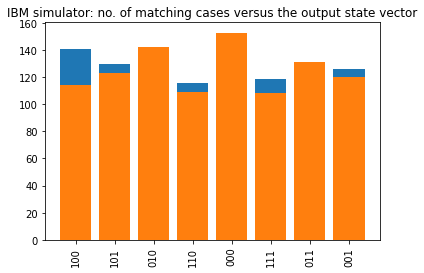

In [ ]:
dic = {0:"does not exist",1: "exists"}
n = 3
m = 5
lis_sam = getFx(m,n,verbose = True)
#[[-3, 1], [-2, 1], [-4, -1], [1, 3], [2, 3], [-1, 2], [-3, -3], [-2, 4], [-3, 4], [-4, 2]]
#getFx(m,n,verbose = True) #[[-2, -1], [1, 2], [2, 2], [-2, 2], [-1, 1], [-1, 2], [-2, 1], [-1, -1], [-2, -2], [1, 1]]

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time, ibm_exec_time, output_dictt,\
ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,m,t,lis_sam,beta_divs = 1, gamma_divs=1, repeats=1000, verbose = True)
#print("histo:", histo)
#print("output_dict:", output_dictt)
print("#######################################")
print("Output interpretation and plots")
if(result>0):
  fin = solution
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for Qiskit simulator execution", exec_time)
  print("Time taken by IBM:", ibm_exec_time)
  print("Histogram of assignments for 1000 repetitions")
  print("histo", histo)
  print("output_dictt", output_dictt)
  pt= process_string(output_dictt, False)
  pt= process_string(ibm_output_dictt, True)



else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")



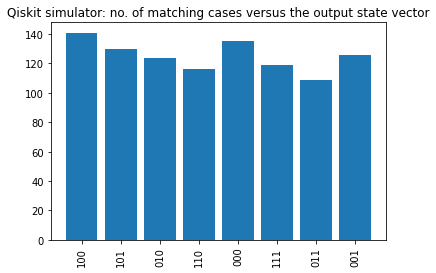

In [ ]:
pt= process_string(output_dictt, False)

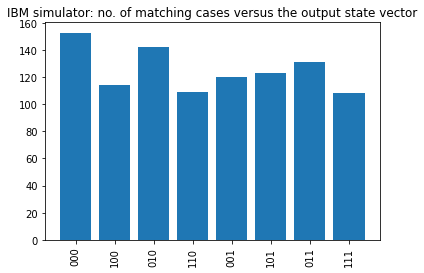

In [ ]:
pt= process_string(ibm_output_dictt, True)

##n=4

repeats (or shots) = 1000


(Beta and gamma divs were kept to 1, for the sake of avoiding too many calls to the IBM simulator, as now the number of qubits being played with reach 5(including helper qubit). It is further known that beta, gamma when taken substantially varied over their respective ranges, will help in amplifying the good state vectors even more.)

configrc.store_credentials:WARNING:2022-03-20 22:20:36,835: Credentials already present. Set overwrite=True to overwrite.


#######################
2-CNF generated:
[[-1, 4], [-2, 4], [-4, 2], [1, 4], [-1, 1]]
Solution: ['0101', '0111', '1101', '1111']
Count 5
#######################
Quantum Circuit:
        ┌───┐   ┌───┐   ┌───┐┌──────────┐   ┌───┐   ┌───┐   ┌───┐    »
q450_0: ┤ H ├───┤ X ├───┤ X ├┤1         ├───┤ X ├───┤ X ├───┤ X ├────»
        ├───┤   ├───┤   ├───┤│          │   └───┘   └───┘┌──┴───┴───┐»
q450_1: ┤ H ├───┤ X ├───┤ X ├┤          ├────────────────┤1         ├»
        ├───┤┌──┴───┴──┐└┬─┬┘│          │                │          │»
q450_2: ┤ H ├┤ Unitary ├─┤M├─┤  Unitary ├────────────────┤          ├»
        ├───┤└──┬───┬──┘ └╥┘ │          │   ┌───┐   ┌───┐│  Unitary │»
q450_3: ┤ H ├───┤ X ├─────╫──┤0         ├───┤ X ├───┤ X ├┤0         ├»
        ├───┤┌──┴───┴──┐  ║  │          │┌──┴───┴──┐└───┘│          │»
q450_4: ┤ X ├┤ Unitary ├──╫──┤2         ├┤ Unitary ├─────┤2         ├»
        └───┘└─────────┘  ║  └──────────┘└─────────┘     └──────────┘»
  c2: 4/══════════════════╩══════════════

ibmqfactory.load_account:WARNING:2022-03-20 22:20:37,588: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:21:28,037: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 0 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:21:28,938: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:21:58,252: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 0
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:21:59,323: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:


configrc.store_credentials:WARNING:2022-03-20 22:22:28,077: Credentials already present. Set overwrite=True to overwrite.


IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
beta_div: i= 1 gamma_div: j= 1
Normal simulator finished
IBM starting


ibmqfactory.load_account:WARNING:2022-03-20 22:22:28,819: Credentials are already in use. The existing account in the session will be replaced.


IBM results obtaining process starts:
IBM results obtaining process ends
IBM accuracy comparisons with the classical output starts
IBM accuracy comparisons with the classical output ends
#######################################
Output interpretation and plots
Quantum Circuit Output:
There exists z satisfies 5 clauses
One of the Assignment which maximizes count =  1101
Number of clauses satisfied 5
Time taken for circuit creation 0.022588729858398438
Time taken for Qiskit simulator execution 0.27964162826538086
Time taken by IBM: 99.4229679107666
Histogram of assignments for 1000 repetitions
histo ['1000', '0100', '0001', '1011', '0111', '1001', '1101', '1010', '0011', '0010', '0110', '0101', '1111', '0000', '1110', '1100']
output_dictt {'1000': 49, '0100': 64, '0001': 66, '1011': 61, '0111': 55, '1001': 61, '1101': 67, '1010': 76, '0011': 59, '0010': 70, '0110': 65, '0101': 47, '1111': 56, '0000': 77, '1110': 66, '1100': 61}


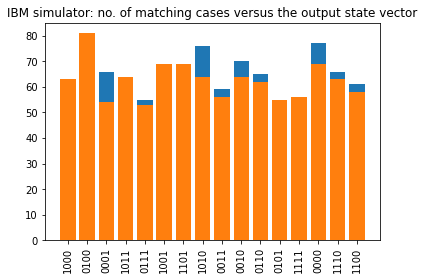

In [ ]:
dic = {0:"does not exist",1: "exists"}
n = 4
m = 5
lis_sam = getFx(m,n,verbose = True)
#[[-3, 1], [-2, 1], [-4, -1], [1, 3], [2, 3], [-1, 2], [-3, -3], [-2, 4], [-3, 4], [-4, 2]]
#getFx(m,n,verbose = True) #[[-2, -1], [1, 2], [2, 2], [-2, 2], [-1, 1], [-1, 2], [-2, 1], [-1, -1], [-2, -2], [1, 1]]

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time, ibm_exec_time, output_dictt,\
ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,m,t,lis_sam,beta_divs = 1, gamma_divs=1, repeats=1000, verbose = True)
#print("histo:", histo)
#print("output_dict:", output_dictt)
print("#######################################")
print("Output interpretation and plots")
if(result>0):
  fin = solution
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for Qiskit simulator execution", exec_time)
  print("Time taken by IBM:", ibm_exec_time)
  print("Histogram of assignments for 1000 repetitions")
  print("histo", histo)
  print("output_dictt", output_dictt)
  pt= process_string(output_dictt, False)
  pt= process_string(ibm_output_dictt, True)



else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")



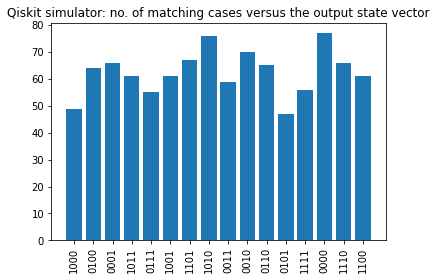

In [ ]:
pt= process_string(output_dictt, False)

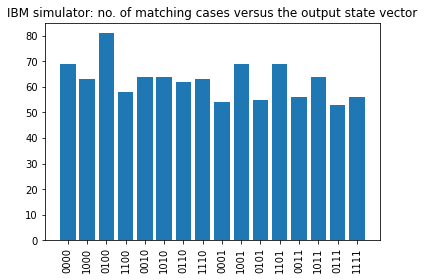

In [ ]:
pt= process_string(ibm_output_dictt, True)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

configrc.store_credentials:WARNING:2022-03-20 22:07:48,073: Credentials already present. Set overwrite=True to overwrite.
configrc.store_credentials:WARNING:2022-03-20 22:08:16,613: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:08:16,852: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:08:46,596: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:08:47,161: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:09:26,814: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:09:27,020: Credentials are already in use. The existing account in the session will be replaced.


  0%|          | 0/1 [00:00<?, ?it/s]

configrc.store_credentials:WARNING:2022-03-20 22:10:06,775: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:10:06,998: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:10:46,865: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:10:47,074: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:11:26,381: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:11:26,536: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:12:06,692: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:12:06,843: Credentials are alread

  0%|          | 0/1 [00:00<?, ?it/s]

configrc.store_credentials:WARNING:2022-03-20 22:12:37,455: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:12:37,865: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:13:16,473: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:13:16,684: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:13:56,940: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:13:57,171: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:14:36,942: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:14:37,181: Credentials are alread

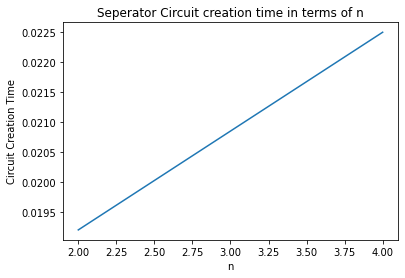

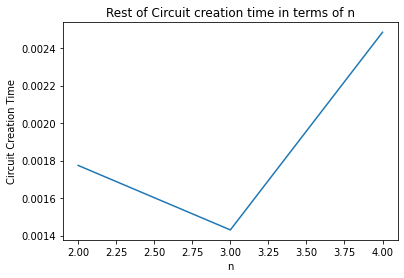

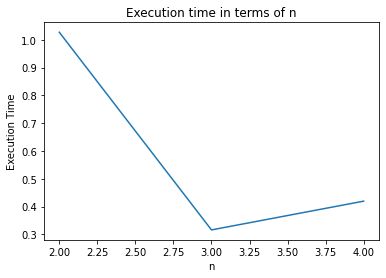

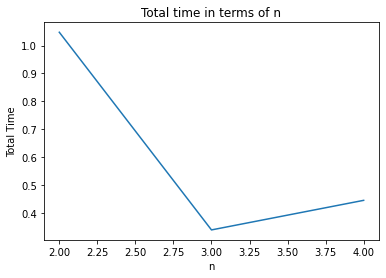

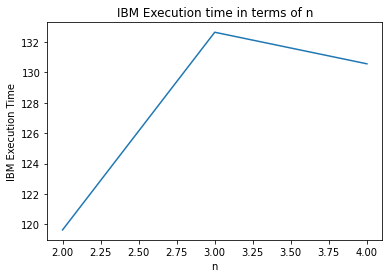

In [ ]:
# Variation of Time vs number of variables
n = 4
m = 10
t = 8

n_c1_time = []
n_c2_time = []
n_e_time = []
total_time = []
ibm_time = []
inside_repeats = 1
n_axis = np.arange(2,n+1)
for i in tqdm(range(2,n+1)):
  temp_qiskit1_time = 0
  temp_qiskit2_time =0 
  temp_exec_time = 0
  for j in tqdm(range(inside_repeats)):
  
    result, histo, solution, max_count, cir_time1, cir_time2 , exec_time, ibm_exec_time, output_dictt,\
    ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(i,m,t,[],beta_divs=1, gamma_divs = 1, repeats = 1000, verbose = False)
    temp_qiskit1_time += cir_time1
    temp_qiskit2_time += cir_time2
    temp_exec_time += exec_time
    
  temp_qiskit1_time /= inside_repeats
  temp_qiskit2_time /= inside_repeats
  temp_exec_time /= inside_repeats
  n_c1_time.append(temp_qiskit1_time)
  n_c2_time.append(temp_qiskit2_time)
  n_e_time.append(temp_exec_time)
  total_time.append(temp_qiskit1_time+temp_qiskit2_time+temp_exec_time)
  ibm_time.append(ibm_exec_time)

plt.plot(n_axis, n_c1_time)  
plt.title('Seperator Circuit creation time in terms of n')
plt.ylabel('Circuit Creation Time')
plt.xlabel('n')
plt.show() 

plt.plot(n_axis, n_c2_time)  
plt.title('Rest of Circuit creation time in terms of n')
plt.ylabel('Circuit Creation Time')
plt.xlabel('n')
plt.show()

plt.plot(n_axis, n_e_time)  
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show()  


plt.plot(n_axis,total_time)  
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show()  

plt.plot(n_axis,ibm_time)  
plt.title('IBM Execution time in terms of n')
plt.ylabel('IBM Execution Time')
plt.xlabel('n')
plt.show()  

## Variation of Time vs number of clauses


  0%|          | 0/6 [00:00<?, ?it/s]

configrc.store_credentials:WARNING:2022-03-20 22:58:04,330: Credentials already present. Set overwrite=True to overwrite.
configrc.store_credentials:WARNING:2022-03-20 22:58:48,686: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:58:49,514: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 22:59:28,063: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 22:59:29,097: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 23:00:08,720: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-20 23:00:09,709: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-20 23:01:59,693: Credentials already 

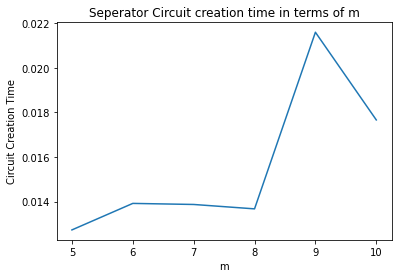

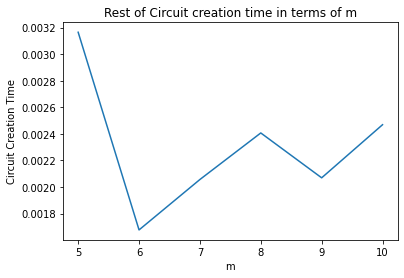

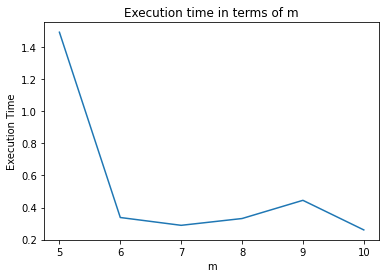

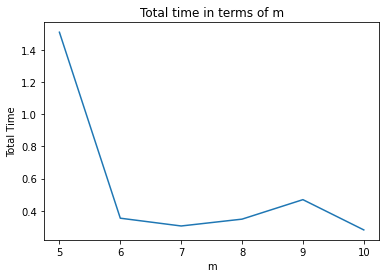

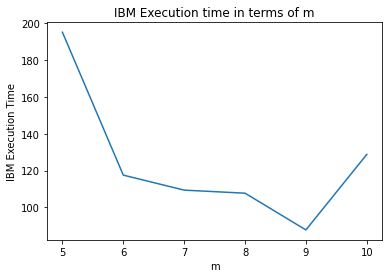

In [ ]:
n = 4
m = 10
t = 3
lis_m = getFx(m,n,verbose = True)
n_c1_time = []
n_c2_time = []
n_e_time = []
total_time = []
ibm_time = []
inside_repeats = 5
n_axis = np.arange(4,m)+1
for i in tqdm(range(5,m+1)):
  result, histo, solution, max_count, cir_time1, cir_time2 , exec_time, ibm_exec_time, output_dictt,\
    ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,i,t,[],beta_divs=1, gamma_divs = 1, repeats = 1000, verbose = False)

  n_c1_time.append(cir_time1)
  n_c2_time.append(cir_time2)
  n_e_time.append(exec_time)
  total_time.append(cir_time1+cir_time2+exec_time)
  ibm_time.append(ibm_exec_time)

plt.plot(n_axis, n_c1_time)  
plt.title('Seperator Circuit creation time in terms of m')
plt.ylabel('Circuit Creation Time')
plt.xlabel('m')
plt.show() 

plt.plot(n_axis, n_c2_time)  
plt.title('Rest of Circuit creation time in terms of m')
plt.ylabel('Circuit Creation Time')
plt.xlabel('m')
plt.show()

plt.plot(n_axis, n_e_time)  
plt.title('Execution time in terms of m')
plt.ylabel('Execution Time')
plt.xlabel('m')
plt.show()  


plt.plot(n_axis,total_time)  
plt.title('Total time in terms of m')
plt.ylabel('Total Time')
plt.xlabel('m')
plt.show()  

plt.plot(n_axis,ibm_time)  
plt.title('IBM Execution time in terms of m')
plt.ylabel('IBM Execution Time')
plt.xlabel('m')
plt.show()  

## Variation of Accuracy vs beta division


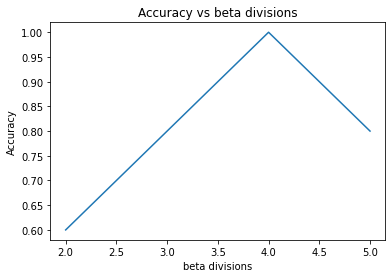

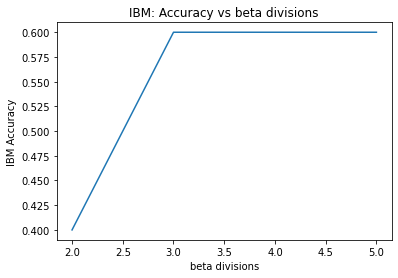

In [ ]:
n = 4
m = 10
lis = []
divs = np.arange(2,6)
repeats_beta = 1
bet_accr = []
bet_accr_ibm = []
for i in range(repeats_beta):
  lis.append(getFx(m,n))

for i in range(len(divs)):
  accr = 0
  ibm_accr = 0

  for t in range(repeats_beta):
    
    _,a = solve(lis[t],n)

    c1 = classical(lis[t],n,a)

    result, histo, solution, max_count, cir_time1, cir_time2 , exec_time, ibm_exec_time, output_dictt,\
        ibm_result, ibm_histo, ibm_solution, ibm_max_count, ibm_output_dictt = runMainCircuit(n,m,a,lis[t],beta_divs = divs[i], gamma_divs = 1, repeats = 1000, verbose = False)
  
    if(c1 == result):
      accr += 1

    if(c1 == ibm_result):
      ibm_accr += 1
  accr /=  repeats_beta
  ibm_accr /= repeats_beta


  bet_accr.append(accr)
  bet_accr_ibm.append(ibm_accr)

plt.plot(divs,bet_accr)  
plt.title('Accuracy vs beta divisions')
plt.ylabel('Accuracy')
plt.xlabel('beta divisions')
plt.show()  

plt.plot(divs,bet_accr_ibm)  
plt.title('IBM: Accuracy vs beta divisions')
plt.ylabel('IBM Accuracy')
plt.xlabel('beta divisions')
plt.show()  

## Variation of Accuracy vs gamma divisions

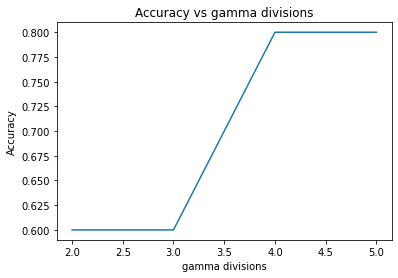

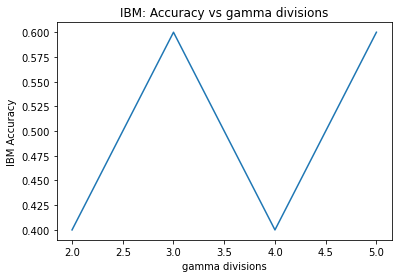

In [ ]:
# Variation of accuracy vs gamma division
n = 4
m = 10
lis = []
divs = np.arange(2,9)
repeats_gam = 20
gam_accr = []
for i in range(repeats_gam):
  lis.append(getFx(m,n))

for i in range(len(divs)):
  accr = 0
  for t in range(repeats_gam):
    
    _,a = solve(lis[t],n)

    c1 = classical(lis[t],n,a)

    c2,_,_,_,_,_,_ = runMainCircuit(n,m,a,lis[t],gamma_divs = divs[i],verbose = False)
  
    if(c1==c2):
      accr += 1
  accr /=  repeats_gam


  gam_accr.append(accr)

plt.plot(divs,gam_accr)  
plt.title('Accuracy vs gamma divisions')
plt.ylabel('Accuracy')
plt.xlabel('gamma divisions')
plt.show()    